# drawing-hares
notebook for prior-informed hare drawing\
*note: this will hopefully be the only notebook in the repo that has external dependence (the grid) - drawn hares will be saved so this should only need running once*

In [40]:
#stock imports
import numpy as np
import pandas as pd
import json
import scipy
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#.script imports
import scripts.prior_funcs as prior_funcs
import scripts.utils as utils

#plt.style.use('dark_background')
plt.style.use('default')

## define priors

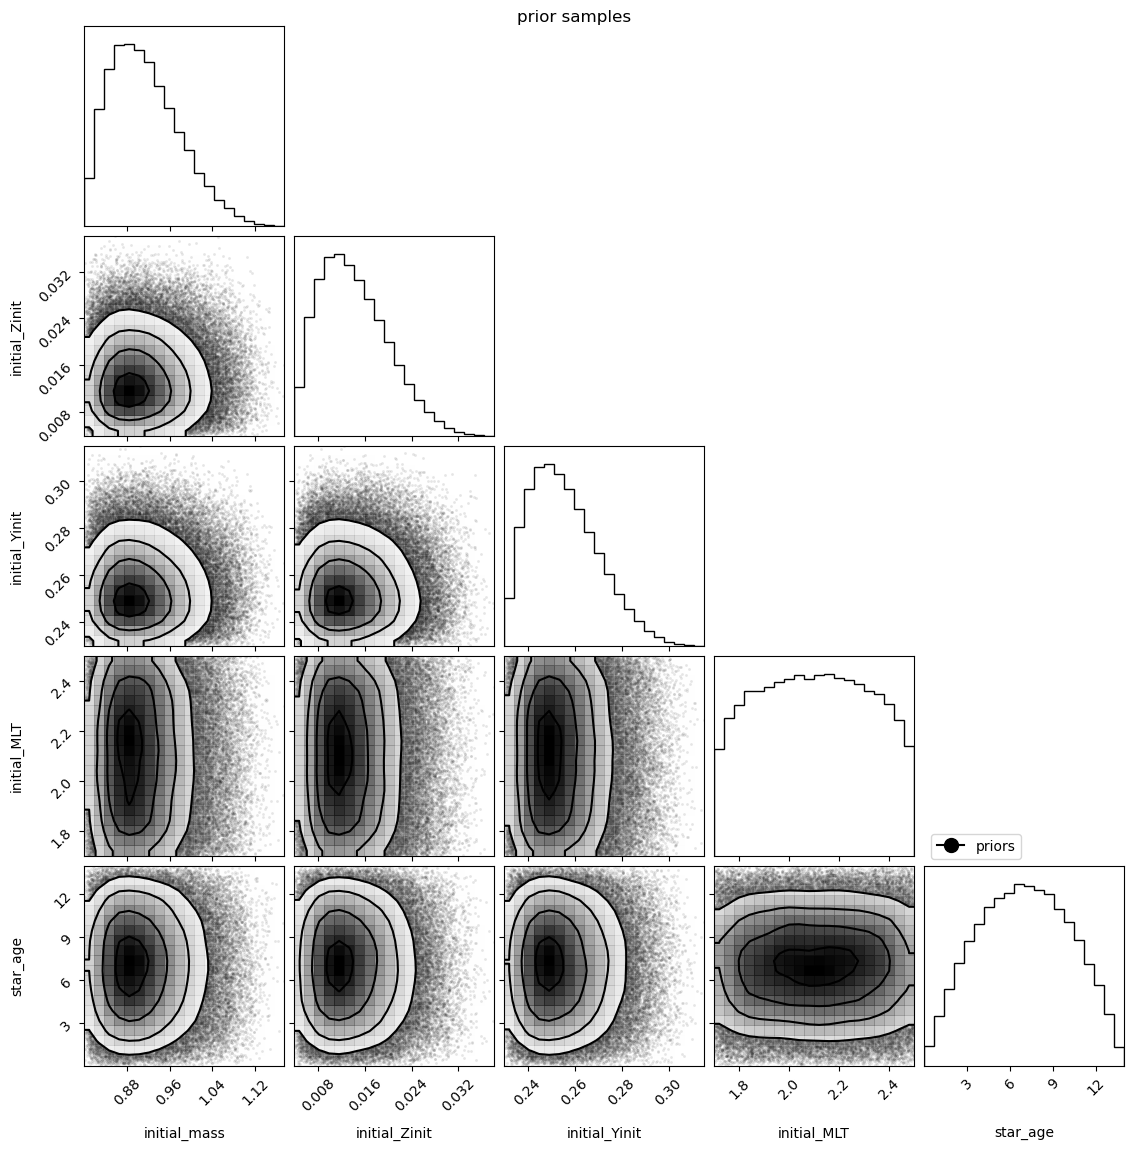

In [52]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.0038, 0.04, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.23, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## import grid
here's where the external grid dependency starts (and hopefully ends)

In [42]:
inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(3,40)]

grid_path = "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5"
grid_df = pd.concat([pd.read_hdf(grid_path, key=f"m{0.8 + i*0.02:.2f}") for i in range(21)], ignore_index=True)

grid_df = grid_df[inputs+outputs]
grid_df['calc_effective_T'] = utils.calc_Teff(grid_df['luminosity'], grid_df['radius'])

## sample from prior and find nearest neighbour (hares)

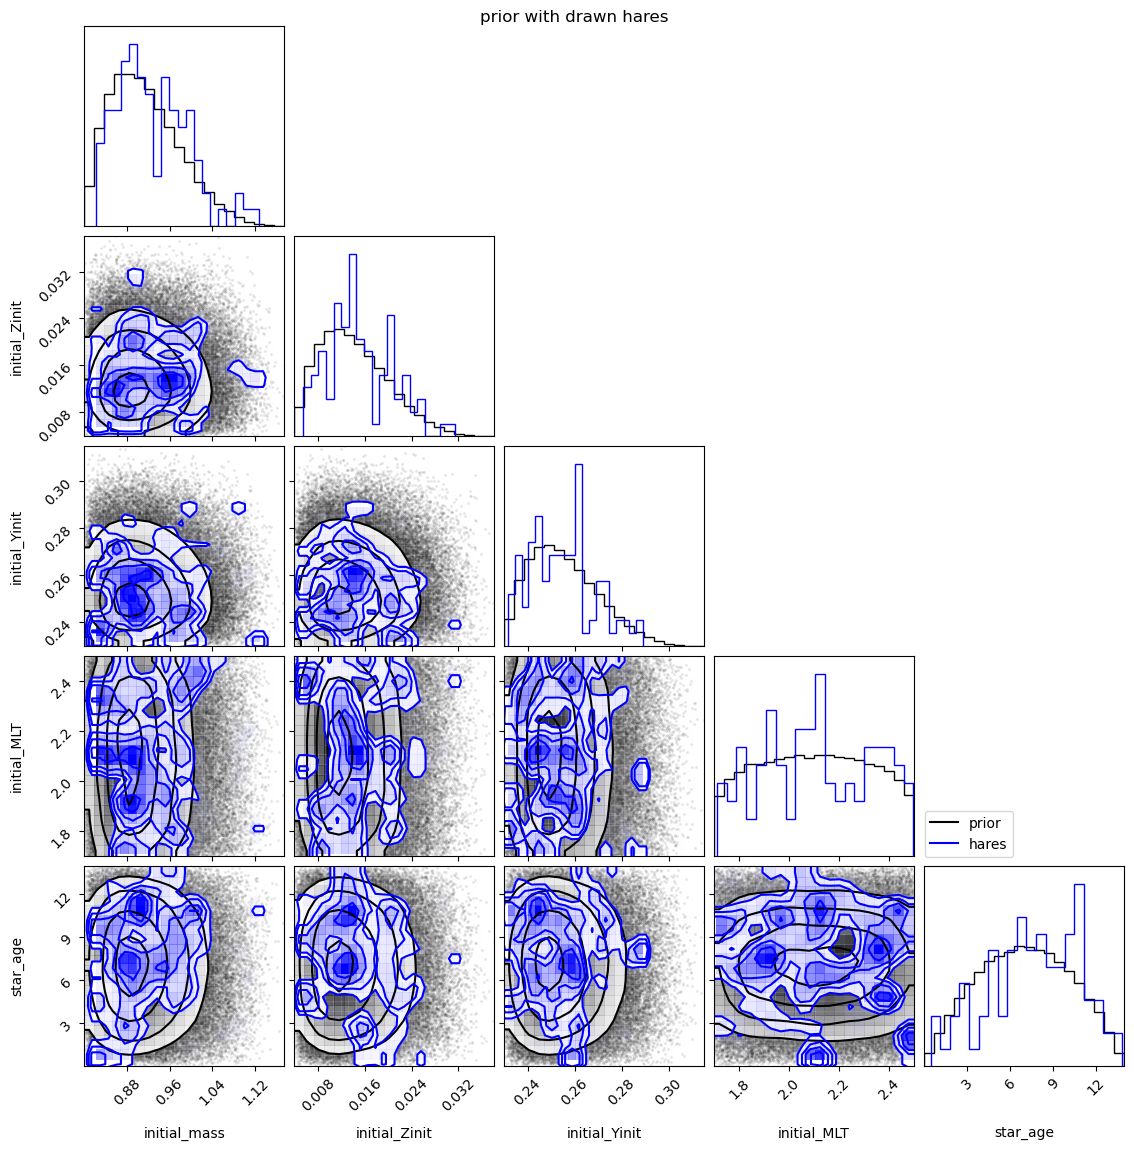

In [120]:
hares_to_sample = 100
prior_samples = np.array([prior.rvs(size=hares_to_sample) for prior in priors])

def corner_legend(color, label):
    return [Line2D([0], [0], marker='', color =color, markerfacecolor = color, markersize=10, label=label)]

#plotting samples over priors:
legend_labels = []

priors_color = 'black'
figure = corner.corner(plot_prior_samples.T, labels = labels,color=priors_color, hist_kwargs={'density':True}, smooth=True);
legend_labels += corner_legend(priors_color, 'prior')

hares_color = 'blue'
corner.corner(prior_samples.T, labels = labels, color=hares_color,hist_kwargs={'density':True}, fig=figure, smooth=True);
legend_labels += corner_legend(hares_color, 'hares')

plt.legend(handles=legend_labels, bbox_to_anchor=(0, 1, .48, 0.31))
plt.suptitle('prior with drawn hares')
plt.show()

In [123]:
from scipy.spatial.distance import cdist
import os

def closest_grid_point(point, grid_df, columns=['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']):
    return grid_df.iloc[[cdist([point], grid_df[columns].values).argmin()]]

for hare_idx in range(hares_to_sample):
    hare_sample = closest_grid_point(prior_samples[:,hare_idx], grid_df)
    path = f'form/hare{hare_idx}'
    if not os.path.exists(path):
      os.mkdir(path)
      print(f"{path} created!")
    else:
      print(f"{path} already exists", end='\r')
    hare_sample.to_json(path+f'/hare{hare_idx}.json')

In [124]:
## add emus here if needed